In [1]:
# Experimenting with tensorflow.org/get_started/eager

# TODO:
# Is defining input_shape necessary? The results (loss over time, accuracy over time) seem very similar
# Compare the efficacy of a few different models

In [2]:
# Imports
import matplotlib.pyplot
import numpy
import pandas
import sklearn.ensemble
import sklearn.linear_model
import sklearn.naive_bayes
import sklearn.neighbors
import sklearn.neural_network
import sklearn.preprocessing
import sklearn.svm
import sklearn.tree
import tensorflow

# TF & Eager
tensorflow.enable_eager_execution()
print("TensorFlow version: {}".format(tensorflow.VERSION))
print("Eager execution: {}".format(tensorflow.executing_eagerly()))

/Users/sam/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow version: 1.8.0
Eager execution: True


In [3]:
# Read in data
train_data_url = 'http://download.tensorflow.org/data/iris_training.csv'
train_data_raw = pandas.read_csv(train_data_url)
train_data_raw.columns = ['petal_length', 'petal_width',
                          'sepal_length', 'sepal_width',
                          'class']

In [4]:
# Convert types from double to float
# ("Cannot compute MatMul as input #0 was expected to be a float tensor but is a double tensor")
# (tf.keras.Sequential: "dtype defaults to self.dtype or float32.")
train_data_raw.iloc[:, :-1] = train_data_raw.iloc[:, :-1].astype(numpy.float32)

In [5]:
# Build Dataset
features_raw = train_data_raw.iloc[:, :-1].as_matrix()
labels_raw   = train_data_raw.iloc[:,  -1].as_matrix()
train_data = tensorflow.data.Dataset.from_tensor_slices((features_raw, labels_raw))

# Randomize & batch
train_data = train_data.shuffle(buffer_size=1000)
train_data = train_data.batch(30)   # Four batches of 30 samples

In [6]:
# Define model architecture with two hidden layers
model = tensorflow.keras.Sequential([
    # The documentation says that input_shape is required
    tensorflow.keras.layers.Dense(units=10, activation='relu', input_shape=(4,)),
    
    # Fully-connected hidden layer
    tensorflow.keras.layers.Dense(units=10, activation='relu'),
    
    # Output one of the three classes [0, 1, 2]    
    tensorflow.keras.layers.Dense(units=3)
])

# Define loss function; use cross-entropy loss / log loss
def loss(model, x, y):
    """ x = features; y = y_true; y_ = y_pred """
    y_ = model(x)
    return tensorflow.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

# Define gradient
def grad(model, inputs, targets):
    with tensorflow.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, model.variables)

# Define optimization; use stochastic gradient descent
optimizer = tensorflow.train.GradientDescentOptimizer(learning_rate=0.01)

In [7]:
# Keep results for plotting
train_loss_results = []
train_accuracy_results = []
num_epochs = 251

# Iterate epochs
for epoch in range(num_epochs):
    epoch_mean_loss = tensorflow.contrib.eager.metrics.Mean()
    epoch_accuracy  = tensorflow.contrib.eager.metrics.Accuracy()
     
    # Train across batches
    for x, y in train_data:
        # Calculate gradient & optimize
        grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.variables),
                                  global_step=tensorflow.train.get_or_create_global_step())
    
        # Calculate current batch loss
        epoch_mean_loss(loss(model, x, y))
        # Get largest probability & compare predicted label to actual label
        epoch_accuracy(tensorflow.argmax(model(x), axis=1), y)

    # End epoch
    train_loss_results.append(epoch_mean_loss.result())
    train_accuracy_results.append(epoch_accuracy.result())
    if epoch % 50 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                    epoch_mean_loss.result(),
                                                                    epoch_accuracy.result()))

Epoch 000: Loss: 1.305, Accuracy: 30.000%
Epoch 050: Loss: 0.951, Accuracy: 70.000%
Epoch 100: Loss: 0.454, Accuracy: 84.167%
Epoch 150: Loss: 0.287, Accuracy: 93.333%
Epoch 200: Loss: 0.196, Accuracy: 96.667%
Epoch 250: Loss: 0.146, Accuracy: 97.500%


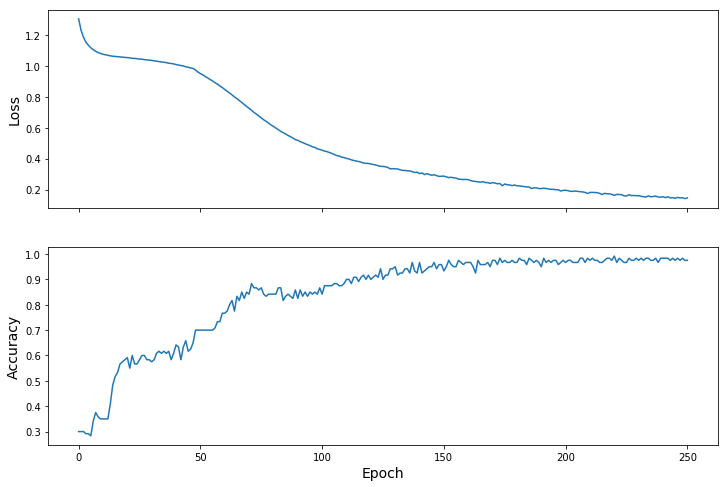

In [8]:
# Plot statistics
fig, axes = matplotlib.pyplot.subplots(2, sharex=True, figsize=(12, 8))
axes[0].set_ylabel('Loss', fontsize=14)
axes[0].plot(train_loss_results)
axes[1].set_ylabel('Accuracy', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=14)
axes[1].plot(train_accuracy_results)
matplotlib.pyplot.show()

In [9]:
random_state = 0
models = {
     'RandomForest_1' : sklearn.ensemble.RandomForestRegressor()
    ,'NaiveBayes'     : sklearn.naive_bayes.GaussianNB()
    ,'Logistic'       : sklearn.linear_model.LogisticRegression()
    ,'KNC_1'          : sklearn.neighbors.KNeighborsClassifier()
    ,'MLP_1'          : sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(10,10),
                                                             max_iter=250)
    ,'SVR'            : sklearn.svm.SVC()
    ,'DecisionTree'   : sklearn.tree.DecisionTreeClassifier()
}
train_accuracies = {
    'TF' : train_accuracy_results[-1].numpy()
}

In [10]:
for model_name in models.keys():
    print(model_name)
    model = models[model_name]
    model = model.fit(features_raw, labels_raw)
    predictions = model.predict(features_raw)
    predictions = pandas.DataFrame(list(zip(predictions, labels_raw)), columns=['y_pred', 'y_true'])
    predictions['hit'] = predictions.apply(lambda x: 1 if x['y_pred'] == x['y_true'] else 0, axis=1)
    train_accuracy = predictions['hit'].mean()
    train_accuracies[model_name] = train_accuracy

RandomForest_1
NaiveBayes
Logistic
KNC_1
MLP_1
SVR
DecisionTree


/Users/sam/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


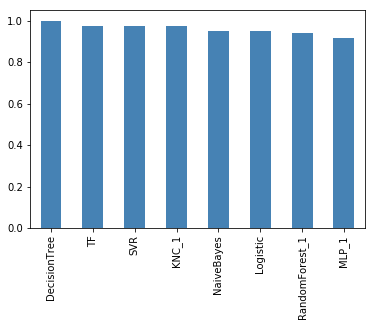

In [11]:
train_accuracies = pandas.Series(train_accuracies).sort_values(ascending=False)
train_accuracies.plot.bar(color='steelblue')
matplotlib.pyplot.show()